# Residual Hearing Machine Learning Model 4

- Sheet 1 데이터의 Gene Classification 을 포함하여 Result_Classification을 분류 
- 총 66개 데이터 
    - X 변수 : 'Age','Gene','Electrode','CDL', 'AID', 'A025(105)','A05(110)'
    - Y 변수 : 'Result Classification' / 다중분류 
- 모델 검증을 위한 데이터 셋 분할
    - 학습데이터 : 46개
    - 검증데이터 : 20개 
- Over Sampling 기법을 이용해, 'Result Classification'에서 데이터 비율을 동등하게 맞추어 학습 
- 앞서 가장 성능이 좋았던 Random Forest Model을 이용해 성능을 더욱 개선

In [84]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats 

pd.options.display.max_columns = 120

**데이터 불러오기**

In [85]:
df1 = pd.read_excel('residual_hearing_ML_0419_sheet1.xlsx')

In [86]:
df1['Gene_clean'] = df1['Gene_Classification'].fillna(0.0)

In [87]:
df1['Electrode_clean'] = df1['Electrode'].replace({'Slim Modiolar':0,'Slim Straight':1})

In [88]:
Y = df1['Result_Classification_3M']
X = df1[['Age at CI','Gene_clean','Electrode_clean','CDL', 
         'AID', 'A025(105)', 'A05(110)']]

**Over Sampling Methods**

In [89]:
from imblearn.over_sampling import SMOTE

In [90]:
sampler = SMOTE()
sampler.fit(X, Y)

SMOTE()

In [91]:
X_over, Y_over = sampler.fit_resample(X, Y)

**Machine Learning Model 구성**

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(X_over, Y_over, test_size=0.4,random_state=1234)

**Random Forest Model**

In [11]:
pipe_list = [('scaler', RobustScaler()),
             ('model',  RandomForestClassifier())]

pipe_model = Pipeline(pipe_list)

In [12]:
hyper_parameter = {'model__max_depth':range(1,20),
                  'model__min_samples_leaf':range(1,20),
                  'model__min_samples_split':range(1,20),
                  'model__class_weight':[None,'balanced','balanced_subsample'],
                  'model__criterion':['gini','entropy'],
                  'model__n_estimators':[50,100,150,200,500]}

grid_model = GridSearchCV(pipe_model, 
                          param_grid=hyper_parameter, cv=5, n_jobs=-1)
grid_model.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.37090909 0.37090909 0.37090909]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced',
                                                 'balanced_subsample'],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 20),
                         'model__min_samples_leaf': range(1, 20),
                         'model__min_samples_split': range(1, 20),
                         'model__n_estimators': [50, 100, 150, 200, 500]})

In [94]:
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_train_pred_proba = best_model.predict_proba(X_train)

Y_test_pred = best_model.predict(X_test)
Y_test_pred_proba = best_model.predict_proba(X_test)

print(best_model)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=11,
                                        min_samples_split=5,
                                        n_estimators=50))])


In [95]:
print('학습 데이터 검증 결과 \n',classification_report(Y_train, Y_train_pred))
print('\n학습 데이터 AUC \n',roc_auc_score(Y_train, Y_train_pred_proba , multi_class='ovr'))
print('\n학습 데이터 F1 Score \n',f1_score(Y_train, Y_train_pred, average='weighted'))

학습 데이터 검증 결과 
               precision    recall  f1-score   support

           1       1.00      0.80      0.89        20
           2       0.80      1.00      0.89        20
           3       1.00      0.93      0.96        14

    accuracy                           0.91        54
   macro avg       0.93      0.91      0.91        54
weighted avg       0.93      0.91      0.91        54


학습 데이터 AUC 
 0.9769607843137255

학습 데이터 F1 Score 
 0.9080932784636488


In [96]:
print(classification_report(Y_test, Y_test_pred))
print('\n검증 데이터 AUC \n',roc_auc_score(Y_test, Y_test_pred_proba , multi_class='ovr'))
print('\n검증 데이터 F1 Score \n',f1_score(Y_test, Y_test_pred, average='weighted'))

              precision    recall  f1-score   support

           1       0.83      0.50      0.62        10
           2       0.47      0.80      0.59        10
           3       0.77      0.62      0.69        16

    accuracy                           0.64        36
   macro avg       0.69      0.64      0.64        36
weighted avg       0.70      0.64      0.64        36


검증 데이터 AUC 
 0.6930288461538462

검증 데이터 F1 Score 
 0.6447335745707394


## ROC

In [97]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [98]:
y_test = pd.get_dummies(Y_test).values

In [99]:
y_score = best_model.predict_proba(X_test)

In [100]:
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [101]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

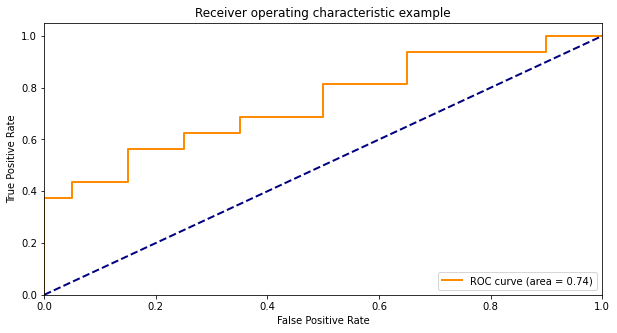

In [105]:
plt.figure(figsize=[10,5])
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

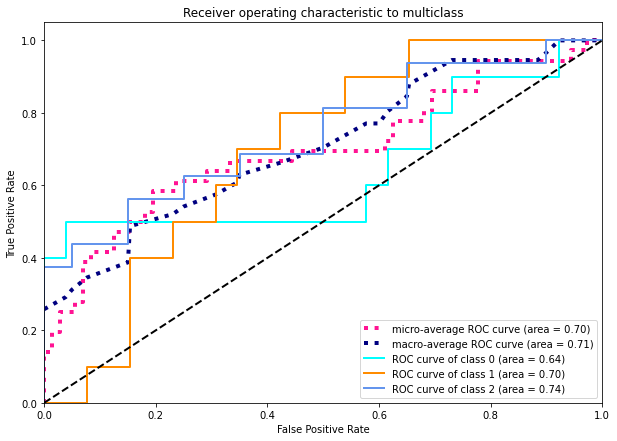

In [107]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[10,7])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )


plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()